In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle
from IPython.display import clear_output

# `Functions`

In [369]:
def display_df_info(dataframe):
    print(f"Shape is: {dataframe.shape}")
    display(dataframe.head())


def get_filtered_data(path_csv_file, element_type, new_value_name):
    data = pd.read_csv(path_csv_file)
    data = data[(data['country_code'].isna() == False) & (data['country_code'] != 'OWID_WRL')]
    data.rename(columns={'year': 'date'}, inplace=True)
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data['year'] = data['date'].dt.year
    data.drop('date', axis=1, inplace=True)

    data = data[data['element'] == element_type]
    data.rename(columns={'value': new_value_name}, inplace=True)
    
    return data[['country_code', 'year', new_value_name]]


def fill_na_with_mean(dataframe, column_name):
    mean = dataframe[column_name].mean()
    dataframe[column_name] = dataframe[column_name].fillna(mean)

    return dataframe


def display_heatmap(dataframe):
    corr=dataframe.corr()

    mask=np.triu(np.ones_like(corr, dtype=bool))     # generate a mask for the upper triangle

    f, ax=plt.subplots(figsize=(11, 9))                 # set up the matplotlib figure

    cmap=sns.diverging_palette(220, 10, as_cmap=True)   # generate a custom diverging colormap

    sns.heatmap(corr, mask=mask, cmap=cmap,             # draw the heatmap with the mask and correct aspect ratio
                vmax=.3, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5})

In [397]:
def compare_models(models, dataframe, label):
    
    fitted_models_list = []
    min_max_scaler_list = []

    r2_list = []
    mse_list = []
    rmse_list = []
    mae_list = []

    for model in models:

        print(f"====== {model} ======")

        dataframe = dataframe.sample(frac=1)

        y = dataframe[label]
        X = dataframe.drop(label, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Scaling data = X_train
        min_max_scaler = MinMaxScaler().fit(X_train)
        X_train_normalized = min_max_scaler.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_normalized = min_max_scaler.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        model.fit(X_train_normalized, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test_normalized)

        # R2 validation
        r2 = r2_score(y_test, y_pred)
        print("R2:", r2)

        # MSE validation
        mse=mean_squared_error(y_test, y_pred)
        print("MSE:", mse)

        # RMSE validation
        rmse = np.sqrt(mse)
        print("RMSE:", rmse)

        # MAE validation
        mae=mean_absolute_error(y_test, y_pred)
        print("MAE:", mae)

        fitted_models_list.append({
            'model': model,
            'min_max_scaler' : min_max_scaler
        })
        min_max_scaler_list.append(min_max_scaler)

        r2_list.append(r2)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)


    summary = {
        'Algorithm': [item['model'] for item in fitted_models_list],
        'R2': r2_list,
        'MSE': mse_list,
        'RMSE': rmse_list,
        'MAE': mae_list
    }
    summary = pd.DataFrame(summary)

    return {
        'summary' : summary,
        'models' : fitted_models_list
    }

In [377]:
def display_ordered_rmse(dataframe_summary):
    clear_output()
    display(dataframe_summary.sort_values(by='RMSE'))

# `UN_paper_pulp_import_export.csv`

In [343]:
file = 'wood-pulp-business/data/cleaned/UN_paper_pulp_import_export.csv'

## `Productions`

In [344]:
paper_pulp_production_data = get_filtered_data(file, 'Production', 'paper_pulp_prod_tonnes')
display_df_info(paper_pulp_production_data)

Shape is: (4346, 3)


,country_code,year,paper_pulp_prod_tonnes
402,ALB,2020,0
403,ALB,2019,0
404,ALB,2018,0
405,ALB,2017,0
406,ALB,2016,0


## `Exports`

In [345]:
paper_pulp_export_data = get_filtered_data(file, 'Export Quantity', 'paper_pulp_export_tonnes')
display_df_info(paper_pulp_export_data)

Shape is: (4663, 3)


,country_code,year,paper_pulp_export_tonnes
56,AFG,2020,22
57,AFG,2019,22
58,AFG,2018,22
59,AFG,2017,19
60,AFG,2016,19


## `Imports`

In [346]:
paper_pulp_import_data = get_filtered_data(file, 'Import Quantity', 'paper_pulp_import_tonnes')
display_df_info(paper_pulp_import_data)

Shape is: (6358, 3)


,country_code,year,paper_pulp_import_tonnes
0,AFG,2020,233
1,AFG,2019,646
2,AFG,2018,140
3,AFG,2017,45
4,AFG,2016,291


# `UN_wood_pulp_import_export.csv`

In [347]:
file = 'wood-pulp-business/data/cleaned/UN_wood_pulp_import_export.csv'

## `Productions`

In [348]:
wood_pulp_production_data = get_filtered_data(file, 'Production', 'wood_pulp_production_tonnes')
display_df_info(wood_pulp_production_data)

Shape is: (3645, 3)


,country_code,year,wood_pulp_production_tonnes
408,ALB,2020,0
409,ALB,2019,0
410,ALB,2018,0
411,ALB,2017,0
412,ALB,2016,0


## `Exports`

In [349]:
wood_pulp_export_data = get_filtered_data(file, 'Export Quantity', 'wood_pulp_export_tonnes')
display_df_info(wood_pulp_export_data)

Shape is: (4555, 3)


,country_code,year,wood_pulp_export_tonnes
56,AFG,2020,38
57,AFG,2019,38
58,AFG,2018,38
59,AFG,2017,35
60,AFG,2016,35


## `Imports`

In [350]:
wood_pulp_import_data = get_filtered_data(file, 'Import Quantity', 'wood_pulp_import_tonnes')
display_df_info(wood_pulp_import_data)

Shape is: (6303, 3)


,country_code,year,wood_pulp_import_tonnes
0,AFG,2020,245
1,AFG,2019,622
2,AFG,2018,127
3,AFG,2017,32
4,AFG,2016,167


# `Concat Dataframes`

In [351]:
data = pd.merge(paper_pulp_production_data, paper_pulp_export_data, on=['country_code', 'year'], how='outer')
data = pd.merge(data, paper_pulp_import_data, on=['country_code', 'year'], how='outer')

data = pd.merge(data, wood_pulp_production_data, on=['country_code', 'year'], how='outer')
data = pd.merge(data, wood_pulp_export_data, on=['country_code', 'year'], how='outer')
data = pd.merge(data, wood_pulp_import_data, on=['country_code', 'year'], how='outer')

display_df_info(data)

Shape is: (11322, 8)


,country_code,year,paper_pulp_prod_tonnes,paper_pulp_export_tonnes,paper_pulp_import_tonnes,wood_pulp_production_tonnes,wood_pulp_export_tonnes,wood_pulp_import_tonnes
0,ALB,2020,0.0,0.0,1794.0,0.0,0.0,29.0
1,ALB,2019,0.0,0.0,23.0,0.0,0.0,23.0
2,ALB,2018,0.0,0.0,1.0,0.0,0.0,1.0
3,ALB,2017,0.0,0.0,0.0,0.0,0.0,0.0
4,ALB,2016,0.0,10.0,4436.0,0.0,25.0,4465.0


# `Concat Paper Prices from producer_paper_price_evolution.csv`

In [352]:
paper_price_data = pd.read_csv('wood-pulp-business/data/cleaned/producer_paper_price_evolution.csv')

paper_price_data.columns = ['date', 'paper_price']
paper_price_data['date'] = pd.to_datetime(paper_price_data['date'], errors='coerce')
paper_price_data['year'] = paper_price_data['date'].dt.year
paper_price_data.drop('date', axis=1, inplace=True)

display_df_info(paper_price_data)

Shape is: (912, 2)


,paper_price,year
0,19.7,1947
1,20.1,1947
2,20.1,1947
3,20.5,1947
4,20.7,1947


In [353]:
paper_price_data = paper_price_data.groupby('year')['paper_price'].mean().reset_index()
display_df_info(paper_price_data)

Shape is: (76, 2)


,year,paper_price
0,1947,20.916667
1,1948,23.025000
2,1949,23.050000
3,1950,23.800000
4,1951,26.908333


In [354]:
data = pd.merge(data, paper_price_data, on=['year'], how='outer')
display_df_info(data)

Shape is: (11338, 9)


,country_code,year,paper_pulp_prod_tonnes,paper_pulp_export_tonnes,paper_pulp_import_tonnes,wood_pulp_production_tonnes,wood_pulp_export_tonnes,wood_pulp_import_tonnes,paper_price
0,ALB,2020,0.0,0.0,1794.0,0.0,0.0,29.0,190.983333
1,DZA,2020,2000.0,24.0,102614.0,NaN,24.0,102617.0,190.983333
2,AGO,2020,0.0,706.0,17642.0,0.0,706.0,17643.0,190.983333
3,ARG,2020,733000.0,193689.0,238613.0,620000.0,193670.0,238536.0,190.983333
4,ARM,2020,0.0,0.0,43.0,0.0,0.0,33.0,190.983333


# `Concat Wood Pulp Prices from producer_wood_pulp_price_evolution.csv`

In [355]:
wood_pulp_price_data = pd.read_csv('wood-pulp-business/data/cleaned/producer_wood_pulp_price_evolution.csv')

wood_pulp_price_data.columns = ['date', 'wood_pulp_price']
wood_pulp_price_data['date'] = pd.to_datetime(wood_pulp_price_data['date'], errors='coerce')
wood_pulp_price_data['year'] = wood_pulp_price_data['date'].dt.year
wood_pulp_price_data.drop('date', axis=1, inplace=True)

display_df_info(wood_pulp_price_data)

Shape is: (1164, 2)


,wood_pulp_price,year
0,10.3,1926
1,10.3,1926
2,10.4,1926
3,10.4,1926
4,10.4,1926


In [356]:
wood_pulp_price_data = wood_pulp_price_data.groupby('year')['wood_pulp_price'].mean().reset_index()
display_df_info(wood_pulp_price_data)

Shape is: (97, 2)


,year,wood_pulp_price
0,1926,10.100000
1,1927,9.316667
2,1928,8.966667
3,1929,8.925000
4,1930,8.741667


In [357]:
data = pd.merge(data, wood_pulp_price_data, on=['year'], how='outer')
display_df_info(data)

Shape is: (11359, 10)


,country_code,year,paper_pulp_prod_tonnes,paper_pulp_export_tonnes,paper_pulp_import_tonnes,wood_pulp_production_tonnes,wood_pulp_export_tonnes,wood_pulp_import_tonnes,paper_price,wood_pulp_price
0,ALB,2020,0.0,0.0,1794.0,0.0,0.0,29.0,190.983333,141.641667
1,DZA,2020,2000.0,24.0,102614.0,NaN,24.0,102617.0,190.983333,141.641667
2,AGO,2020,0.0,706.0,17642.0,0.0,706.0,17643.0,190.983333,141.641667
3,ARG,2020,733000.0,193689.0,238613.0,620000.0,193670.0,238536.0,190.983333,141.641667
4,ARM,2020,0.0,0.0,43.0,0.0,0.0,33.0,190.983333,141.641667


# `Work on the model`

In [358]:
data.to_csv('data/data.csv')

In [359]:
cols = ['paper_pulp_prod_tonnes', 'paper_pulp_export_tonnes', 'paper_pulp_import_tonnes', 'wood_pulp_production_tonnes', 'wood_pulp_export_tonnes', 'wood_pulp_import_tonnes', 'paper_price']

for col in cols:
    data = fill_na_with_mean(data, col)

In [360]:
data.isna().sum()

country_code                   37
year                            0
paper_pulp_prod_tonnes          0
paper_pulp_export_tonnes        0
paper_pulp_import_tonnes        0
wood_pulp_production_tonnes     0
wood_pulp_export_tonnes         0
wood_pulp_import_tonnes         0
paper_price                     0
wood_pulp_price                 0
dtype: int64

In [361]:
data.drop('country_code', axis=1, inplace=True)

In [362]:
display_df_info(data)

Shape is: (11359, 9)


,year,paper_pulp_prod_tonnes,paper_pulp_export_tonnes,paper_pulp_import_tonnes,wood_pulp_production_tonnes,wood_pulp_export_tonnes,wood_pulp_import_tonnes,paper_price,wood_pulp_price
0,2020,0.0,0.0,1794.0,0.000000e+00,0.0,29.0,190.983333,141.641667
1,2020,2000.0,24.0,102614.0,2.989767e+06,24.0,102617.0,190.983333,141.641667
2,2020,0.0,706.0,17642.0,0.000000e+00,706.0,17643.0,190.983333,141.641667
3,2020,733000.0,193689.0,238613.0,6.200000e+05,193670.0,238536.0,190.983333,141.641667
4,2020,0.0,0.0,43.0,0.000000e+00,0.0,33.0,190.983333,141.641667


## `Check correlations`

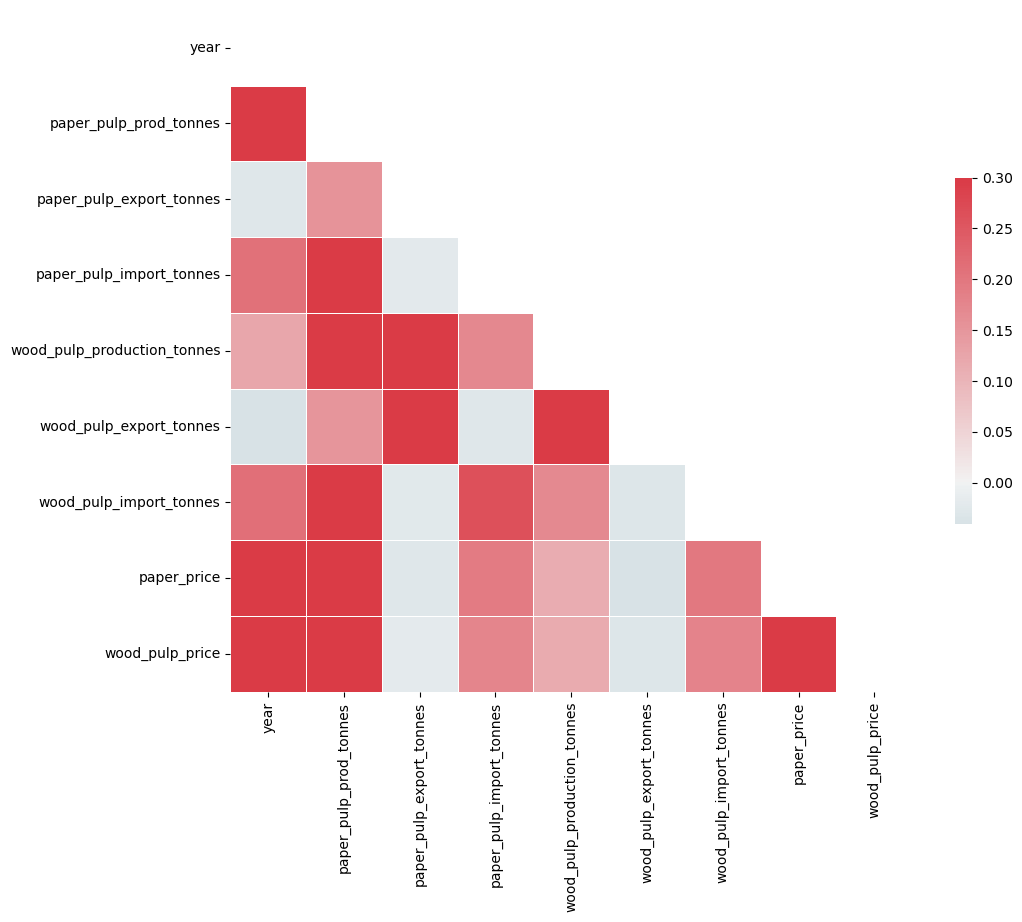

In [370]:
display_heatmap(data)

## `Test algorithms`

In [390]:
models_to_test = [
    LinearRegression(n_jobs=-1),
    Lasso(),
    Ridge(),
    ElasticNet(),
    XGBRegressor(),
    LGBMRegressor(n_jobs=-1),
    DecisionTreeRegressor(),
    KNeighborsRegressor(n_jobs=-1),
    MLPRegressor(),
    RandomForestRegressor(n_jobs=-1)
]

In [398]:
results_paper_price = compare_models(models=models_to_test, dataframe=data.drop('wood_pulp_price', axis=1), label='paper_price')
display_ordered_rmse(results_paper_price['summary'])

,Algorithm,R2,MSE,RMSE,MAE
4,"XGBRegressor(base_score=0.5, booster='gbtree',...",1.000000,0.000869,0.029486,0.002160
9,"(DecisionTreeRegressor(max_features='auto', ra...",0.999984,0.029428,0.171546,0.004764
6,DecisionTreeRegressor(),0.999763,0.444979,0.667067,0.015583
5,LGBMRegressor(),0.996931,5.789388,2.406115,0.132510
7,KNeighborsRegressor(n_jobs=-1),0.996256,6.644796,2.577750,0.724556
0,LinearRegression(n_jobs=-1),0.935827,121.604693,11.027452,7.479504
8,MLPRegressor(),0.930480,125.851161,11.218340,7.206695
2,Ridge(),0.903536,177.220119,13.312405,7.661787
1,Lasso(),0.879664,226.276521,15.042491,9.346985
3,ElasticNet(),0.084349,1522.116761,39.014315,29.204501


In [411]:
# LinearRegression(n_jobs=-1) seems the best

paper_price_model_with_scaler = results_paper_price['models'][0]

with open(f'data/models/paper_price_model_with_scaler.pkl', 'wb') as file:
    pickle.dump(paper_price_model_with_scaler, file)

In [405]:
results_wood_pulp_price = compare_models(models=models_to_test, dataframe=data.drop('paper_price', axis=1), label='wood_pulp_price')
display_ordered_rmse(results_wood_pulp_price['summary'])

,Algorithm,R2,MSE,RMSE,MAE
4,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.999492,1.087308,1.042741,0.056613
9,"(DecisionTreeRegressor(max_features='auto', ra...",0.998861,2.468427,1.571123,0.078556
5,LGBMRegressor(),0.998081,3.956591,1.989118,0.174485
6,DecisionTreeRegressor(),0.997540,4.854919,2.203388,0.116127
7,KNeighborsRegressor(n_jobs=-1),0.980313,41.183724,6.417455,1.916661
0,LinearRegression(n_jobs=-1),0.813431,380.669806,19.510761,15.285415
8,MLPRegressor(),0.809903,387.888326,19.694881,15.261744
2,Ridge(),0.804925,395.464631,19.886293,15.390221
1,Lasso(),0.768121,466.257209,21.592990,16.935783
3,ElasticNet(),0.071449,1888.702976,43.459210,33.679356


In [418]:
# KNeighborsRegressor(n_jobs=-1) seems the best

wood_pulp_price_model_with_scaler = results_wood_pulp_price['models'][-3]

with open(f'data/models/wood_pulp_price_model_with_scaler.pkl', 'wb') as file:
    pickle.dump(wood_pulp_price_model_with_scaler, file)